# SFM

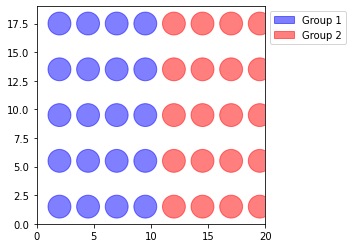

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
from math import cos, sin, pi
from IPython.display import HTML, Video, display

"""
-----------------------
Helper Functions: Later move it to another file.py
-----------------------

"""
def selfPropulsionForce(m, tau, desiredSpeed, desiredDirection, velocity):
    desiredVelocity = desiredSpeed * desiredDirection
    return (desiredVelocity - velocity) * (m / tau)

def wallForce(position, R, A,  B, Ly,t):
    
    N = position.shape[0]
    # return np.zeros((N,2))
    y = position[:, 1]
    dist_from_walls=np.zeros((N,2))
    dist_from_walls[:,0]=y
    dist_from_walls[:,1]=Ly-y
    # print(dist_from_walls)
    if dist_from_walls.min()<R:
        print('some agent is too close to the wall')
        print(position[np.where(dist_from_walls==dist_from_walls.min())[0][0]],t)
        raise ValueError('some agent is too close to the wall')
    closest_wall=np.argmin(dist_from_walls,axis=1)
    bottom_force_indices=(closest_wall==0)*(dist_from_walls[:,0]<3*R)
    top_force_indices=(closest_wall==1)*(dist_from_walls[:,1]<3*R)
    force = np.zeros_like(position)
    force[bottom_force_indices,1]=A*np.power(dist_from_walls[bottom_force_indices,0]-R,-B)
    force[top_force_indices,1]=-A*np.power(dist_from_walls[top_force_indices,1]-R,-B)
    return force

def interactionForce(position, R, A, B, Lx, Ly):
    N = position.shape[0]
    epsilon = 1e-6 # Used to avoid infinity
    agent_size = 2 * R

    x = position[:, 0].reshape(-1, 1)
    y = position[:, 1].reshape(-1, 1)

    dx = x - x.T
    dy = y - y.T


    dx_u = dx - np.round(dx / Lx) * Lx
    dy_u = dy

    # Euclidean distance calculation
    dist = np.sqrt(dx_u**2 + dy_u**2)
    
    valid_index = (dist < (3*R)) & (dist > 0)

    # Unit vectors
    dij_x = np.zeros_like(dist)
    dij_y = np.zeros_like(dist)
    np.divide(dx_u, dist, out=dij_x, where=dist>epsilon)
    np.divide(dy_u, dist, out=dij_y, where=dist>epsilon)   
    # np.divide(dx_u, dist+epsilon, out=dij_x)#, where=dist>epsilon)
    # np.divide(dy_u, dist+epsilon, out=dij_y)#, where=dist>epsilon)
    
    # Apply valid_index mask
    dij_x[~valid_index] = 0
    dij_y[~valid_index] = 0
    
    # Effective distance
    effective_dist = np.maximum(dist - agent_size, epsilon)
    
    # Force magnitude calculation
    force_magnitude = np.zeros_like(dist)
    np.power(effective_dist, -B, out=force_magnitude, where=effective_dist>epsilon)
    force_magnitude *= -A
    
    force_magnitude[~valid_index] = 0

    interaction_force = np.column_stack((np.sum(force_magnitude * dij_x, axis=0),np.sum(force_magnitude * dij_y, axis=0)))

    return interaction_force


"""
--------------------------------
code starts here
--------------------------------
"""
# Current case




Lx=20
Ly=19
R = 1


Nr = 1/2

case = "Lane_Formation"
title = "Lane Formation"


simArea = Lx*(Ly-6)


N=40

total_area_occupied = N * np.pi * R**2
total_simulation_area = Lx*Ly

# number of agent in each group
g1 = int(round(N * Nr))
# g1=1
g2 = N - g1

# Initial Position
position=np.array(sum([[[x,y] for y in [1.5,5.5,9.5,13.5,17.5]] for x in [2,4.5,7,9.5,12,14.5,17,19.5]],[]))#[np.random.permutation(np.arange(N))]
# position=np.array(sum([[[x,y] for y in [1.25,3.75,6.25,8.75,11.25,13.75,16.25,18.75]] for x in [2,4.5,7,9.5,12,14.5,17,19.5]],[]))#[np.random.permutation(np.arange(N))]
# position=np.array([[6,10],[13,10]])
# position=np.array([[4.5,9.5]]+sum([[[x,y] for y in [1.5,5.5,9.5,13.5,17.5]] for x in [12,14.5,17,19.5]],[]))
# position=startpos.copy()[np.random.permutation(np.arange(90))]
position=position+(np.random.random(size=position.shape)-0.5)*0.001
position[:,0]=position[:,0]%Lx

# Initial Speed
speed = 0

# Initial Direction
theta = np.random.uniform(0, 2* np.pi, size = (N, 1))
# theta = np.ones(shape=(N,1))*np.pi/2
# theta=np.array([[0],[np.pi]])
# print(theta)
# Parameter for force calculation
m = 1
A = 0.01
B = 3
tau = 1

# Inital velocity
velocity = speed * np.column_stack((np.cos(theta), np.sin(theta)))

# Desired speed
desiredSpeed = np.ones((N,1)) * 1
# desiredSpeed[:g1] = 0


# Desired direction
desiredDirectionA = np.ones((N, 1))
desiredDirectionA[:g1] = 0
desiredDirectionA[g1:] = np.pi
desired=(desiredDirectionA.copy()).ravel()
desiredDirection = np.hstack((np.cos(desiredDirectionA), np.sin(desiredDirectionA)))

# Desired velocity
# desiredVelocity = desiredSpeed * desiredDirection


# Time parameters
deltaT = 0.005
timeStep = 35000
totalTime = deltaT*timeStep

fig, ax = plt.subplots()

# Circle patches for each group
circles_g1 = [patches.Circle((position[i, 0], position[i, 1]), radius=R, color='blue',alpha=0.5, label='Group 1' if i == 0 else "") for i in range(g1)]
circles_g2 = [patches.Circle((position[i, 0], position[i, 1]), radius=R, color='red',alpha=0.5, label='Group 2' if i == g1 else "") for i in range(g1, len(position))]
for circle in circles_g1 + circles_g2:
    ax.add_patch(circle)

# ax.set_title(f"{title} | Density = {density} | Nr = {round(Nr, 2)}")
ax.set_xlim([0, Lx])
ax.set_ylim([0, Ly])
ax.set_aspect('equal', 'box')
ax.legend(loc = 'upper left',  bbox_to_anchor=(1, 1), markerscale=0.5)
plt.savefig(f"InitialMulti_{case}.png")

xData = []
yData = []

uData = []
vData = []

xData.append(position[:,0])
yData.append(position[:,1])

uData.append(velocity[:,0])
vData.append(velocity[:,1])


# FSM

In [2]:
# Imports and Initializations

import portion as P
import numpy as np
import matplotlib.pyplot as plt
import cmath
from parfor import parfor
import csv
from tqdm import tqdm

In [3]:
# Setting model parameters
deltheta=np.pi/8
numagents=N
tau_fut=6
agentradius=R

numsamp=50

def periodify(pos,width):
    if len(pos.shape)==1:
        pos[0]=pos[0]%width
    else:
        pos[:,0]=pos[:,0]%width
    return pos



def getdisp(a,b):
    disp=a-b
    if len(disp.shape)==1:
        disp[0]=disp[0]-np.round(disp[0]/Lx)*Lx
    else:
        disp[:,0]=disp[:,0]-np.round(disp[:,0]/Lx)*Lx
    return disp

# functions related to sensors/boundaries


def distance_from_boundary(agentpos):
    ypos=agentpos[1]
    return min(ypos,Ly-ypos)

In [4]:
def updatepos(agentpos,agentdir,v):
    return periodify(agentpos+np.array([v*np.cos(agentdir),v*np.sin(agentdir)]),Lx)

def getstate(agentposdir, agent, othersposes,grad):
    return tuple([0,0,np.round(agentposdir[0][0],6),np.round(agentposdir[0][1],6)]+[np.round(np.exp(grad) if grad<0 else 1+np.log(1+grad),6)])


def getbest(stateslists):
    outs=[]
    for statelist in stateslists:
        statematrix=np.array(list(set(statelist)))
        if statematrix.shape[0]==0:
            score=-1
        else:
            gradmat=statematrix[:,-1]
            statematrix=statematrix[:,:-4]
            score=gradmat.sum()
        outs.append(score)
    return randargmax(np.array(outs))
    
def randargmax(b):
    return np.random.choice(np.where(b == b.max())[0])


# def findposesovertime(agentsposes,agentsdirs,agentsvels,tau_fut):
#     # return [np.ones_like(agentsposes)*80]*(1+tau_fut)
#     posesovertime=[]
#     posesovertime.append(agentsposes)
#     newposes=agentsposes.copy()
#     newdirs=agentsdirs.copy()
#     for i in range(tau_fut):
#         newposes=newposes+agentsvels.reshape(-1,1)*np.vstack([np.cos(newdirs),np.sin(newdirs)]).T
#         # for agent in range(numagents):
#         #     newposes[agent],newdirs[agent]=reflect_circularwall(newposes[agent],newdirs[agent],0)
#         newpos,newdirs=reflect_boundary(newposes.copy(),newdirs)
#         posesovertime.append(periodify(newpos,Lx))
#     return posesovertime



def findposesovertime(agentsposes,agentsdirs,agentsvels,tau_fut):
    agentsvels=np.vstack((agentsvels*np.cos(agentsdirs),agentsvels*np.sin(agentsdirs))).T
    numagents=len(agentsposes)
    v0=agentsvels-calcphi(agentsposes,agentsvels)
    posesovertime=[agentsposes]
    newposes=agentsposes.copy()
    newvels=agentsvels.copy()
    newposes=newposes+newvels
    newposes,newdirs=reflect_boundary(newposes,agentsdirs)
    posesovertime.append(periodify(newposes.copy(),Lx))
    for t in range(2,tau_fut+1):
        newvels=calcphi(newposes,newvels)+v0
        newdirs=np.arctan2(newvels[:,1],newvels[:,0])
        newposes=newposes+newvels
        newposes,newdirs=reflect_boundary(newposes,newdirs)
        posesovertime.append(periodify(newposes.copy(),Lx))
    return posesovertime

def calcphi(agentsposes,agentsvels):
    mu=1
    interboundary=3*agentradius
    xposes=agentsposes[:,0].reshape(-1,1)
    yposes=agentsposes[:,1].reshape(-1,1)
    xdisps=(xposes.T-xposes)
    xdisps=xdisps - np.round(xdisps / Lx) * Lx
    ydisps=yposes.T-yposes
    dists=(xdisps**2+ydisps**2)**0.5-np.eye(numagents)
    interactings=(dists<interboundary)*(dists>=0)
    interactings2=np.zeros_like(interactings)
    interactings2[interactings]=interboundary/dists[interactings]
    xdisps=xdisps/dists
    ydisps=ydisps/dists
    disps=np.array([xdisps,ydisps])
    phi=np.einsum('jd,dji,sji,ij->is',agentsvels,disps,disps,interactings2)
    interactings2=interactings2.sum(axis=1)
    phi[interactings2>0,:]=phi[interactings2>0,:]/interactings2[interactings2>0].reshape(-1,1)
    return phi

def reflect_boundary(poses1,dirs1):
    onedim=False
    if len(poses1.shape)==1:
        poses1=np.array([poses1])
        dirs1=np.array([dirs1])
        onedim=True
    dirs=dirs1.copy()
    poses=poses1.copy()
    above=poses[:,1]>Ly-R
    below=poses[:,1]<R
    poses[above,1]=2*(Ly-R)-poses[above,1]
    poses[below,1]=2*(R)-poses[below,1]
    dirs[above]=np.arctan2(-np.sin(dirs[above]),np.cos(dirs[above]))%(2*np.pi)
    dirs[below]=np.arctan2(-np.sin(dirs[below]),np.cos(dirs[below]))%(2*np.pi)
    if not onedim:
        return poses,dirs
    else:
        return poses[0],dirs[0]
def make_moveset(agentpos,agentdir,v):
    dircombs=[(agentdir+deltheta)%(2*np.pi),agentdir,(agentdir-deltheta)%(2*np.pi),(agentdir-2*deltheta)%(2*np.pi),(agentdir+2*deltheta)%(2*np.pi)]
    # dircombs=[(agentdir+deltheta)%(2*np.pi),agentdir,(agentdir-deltheta)%(2*np.pi)]
    # dircombs = [i for i in np.arange(0,2*np.pi-0.0001,np.pi/5)]
    # tempvelcombs=[v-delv,v,v+delv]
    # velcombs=[]
    # for vel in tempvelcombs:
    #     if vel>=minvel and vel<=maxvel:
    #         velcombs.append(vel)
    velcombs=[v]
    moveset=[]
    for vel in velcombs:
        for dir in dircombs:
            moveset.append([vel,dir])
    return moveset


def reflect_nearest(agentpos,agent,othersposes):
    disps=getdisp(othersposes,agentpos)
    disps=np.delete(disps,agent,axis=0)
    dists=((disps**2).sum(axis=1))**0.5
    minarg=dists.argmin()
    if dists[minarg]<2*R:
        mag=2*R-dists[minarg]
        dir=np.arctan2(-disps[minarg][1],-disps[minarg][0])
        newpos=agentpos+[2*mag*np.cos(dir),2*mag*np.sin(dir)]
        return reflect_boundary(periodify(newpos,Lx),dir)[0]
    return agentpos
        
def randevolve(numsamp,agentpos,agentdir, agent, othersposesovertime, move, k,tau_fut,velprobs,thetprobs):
    v=1 ##################### this was move[0] before
    outposes=[]
    ogpos=agentpos
    ogpos=agentpos
    # othersposes=othersposesovertime[0]
    othersposes=othersposesovertime[1]
    newagentdir=(move[1])%(2*np.pi)
    newagentposdir=[reflect_nearest(updatepos(agentpos,newagentdir,v),agent,othersposes),newagentdir]
    for samp in range(numsamp):
        newpos,newdir=newagentposdir.copy()
        a,b=newpos.copy(),newdir
        for t in range(2,tau_fut+1):
            newdir=newdir+np.random.choice([-deltheta,-2*deltheta,0,deltheta,2*deltheta])#,p=thetprobs)
            # newdir=np.random.choice([i for i in np.arange(0,2*np.pi-0.0001,np.pi/5)])
            newpos=reflect_nearest(updatepos(newpos,newdir,v),agent,othersposesovertime[t])
        outposes.append(getstate([newpos,newdir],agent,othersposesovertime[t],getdisp(newpos,ogpos)@np.array([np.cos(desired[agent]),np.sin(desired[agent])])))
    return outposes

# Parallel

In [5]:
from tqdm import tqdm
updateT=tau
updateF=round(updateT/deltaT)
desdirs=[]
forces=[]
for t in tqdm(range(timeStep)):
    if t*deltaT>-13:
        if t%updateF==updateF-1:
            # print(t)
            agentsposes=position
            agentsdirs=np.arctan2(velocity[:,1],velocity[:,0])%(2*np.pi)
            agentsvels=updateT*((velocity[:,1])**2+(velocity[:,0])**2)**0.5
            agentsposesovertime=findposesovertime(agentsposes,agentsdirs,agentsvels,tau_fut)
            # print(time)
            chosenmoves=[]
            @parfor(range(numagents),bar=False)
            def paragent(focal):
                stateslists=[]
                agentpos=agentsposes[focal]
                agentdir=agentsdirs[focal]
                agentvel=agentsvels[focal]
                moveset=make_moveset(agentpos,agentdir,agentvel)
                for move in moveset:
                    evolvelist=randevolve(numsamp,agentpos,agentdir,focal,agentsposesovertime,move,1,tau_fut,[1/3]*3,[1/10]*10)
                    stateslists.append(evolvelist)
                chosen=getbest(stateslists)
                return moveset[chosen]
            chosenmoves=np.array(paragent)
            # desiredSpeed=chosenmoves[:,0].reshape(-1,1)
            desiredDirectionA=(chosenmoves[:,1]).reshape(-1,1)
            desiredDirection = np.hstack((np.cos(desiredDirectionA), np.sin(desiredDirectionA)))
    desdirs.append(desiredDirection[:].copy())
  # Force calculation
    f1 = selfPropulsionForce(m, tau, desiredSpeed, desiredDirection, velocity)
    f2 = interactionForce(position, R, A, B, Lx,Ly)
    f3 = wallForce(position, R, A, B, Ly,t)
    force = (f1+f2+f3)/m

    # newPosition = np.add(position, np.multiply(newVelocity, np.ones((N, 1))*deltaT))
    newPosition = position + (velocity * deltaT) + (0.5 * force * deltaT**2)
    newPosition[:,0] = (newPosition[:,0]) % Lx

    # force = 0
    deltaV = force * deltaT

    vint = velocity + deltaV

    f1_new = selfPropulsionForce(m, tau, desiredSpeed, desiredDirection, vint) 
    f2_new =  interactionForce(newPosition, R, A, B, Lx,Ly)
    f3_new = wallForce(newPosition, R, A, B, Ly,t)
    forceNew = (f1_new + f2_new + f3_new)/m
    
    newVelocity = velocity + (0.5 * (force + forceNew)) * deltaT

    velocity = newVelocity
    position = newPosition
    
    # plt.pause(0.001)
    
    # Stroing the data
    xData.append(newPosition[:,0])
    yData.append(newPosition[:,1])
    
    uData.append(newVelocity[:,0])
    vData.append(newVelocity[:,1])
    forces.append([f1,f2,f3])
    # if t==2500:
    #     check=agentsposesovertime.copy()
    # f3s.append(f3)
plt.show()

# Converting the data structure for later use

100%|████████████████████████████████████████████████████████████████████████████| 35000/35000 [02:21<00:00, 247.91it/s]


# Serial

In [ ]:
updateT=tau
updateF=round(updateT/deltaT)
# desses=[]
forces=[]
waiting_time=np.random.exponential(tau, size=N)
gradmats=[]
desdirs=[]
desdirs.append(desiredDirection[:].copy())
for t in tqdm(range(timeStep)):
    waiting_time-=deltaT
    updateinds=np.arange(N)[waiting_time<=0]
    waiting_time[updateinds]=np.random.exponential(tau, size=len(updateinds))
    if len(updateinds)>0:
        # print(t)
        agentsposes=position
        agentsdirs=np.arctan2(velocity[:,1],velocity[:,0])%(2*np.pi)
        agentsvels=updateT*((velocity[:,1])**2+(velocity[:,0])**2)**0.5
        agentsposesovertime=findposesovertime(agentsposes,agentsdirs,agentsvels,tau_fut)
        agentsposes=agentsposesovertime[0]
        # print(time)
        chosenmoves=[]
        for focal in updateinds:
            stateslists=[]
            agentpos=agentsposes[focal]
            agentdir=agentsdirs[focal]
            agentvel=agentsvels[focal]
            moveset=make_moveset(agentpos,agentdir,agentvel)
            for move in moveset:
                evolvelist=randevolve(numsamp,agentpos,agentdir,focal,agentsposesovertime,move,1,tau_fut,[1/3]*3,[1/5]*5)
                stateslists.append(evolvelist)
            chosen=getbest(stateslists)
            chosenmove=moveset[chosen]
            desiredDirection[focal,:]=np.array([np.cos(chosenmove[1]),np.sin(chosenmove[1])])
    desdirs.append(desiredDirection[:].copy())
  # Force calculation
    f1 = selfPropulsionForce(m, tau, desiredSpeed, desiredDirection, velocity)
    f2 = interactionForce(position, R, A, B, Lx,Ly)
    f3 = wallForce(position, R, A, B, Ly,t)
    force = (f1+f2+f3)/m

    # newPosition = np.add(position, np.multiply(newVelocity, np.ones((N, 1))*deltaT))
    newPosition = position + (velocity * deltaT) + (0.5 * force * deltaT**2)
    newPosition[:,0] = (newPosition[:,0]) % Lx

    # force = 0
    deltaV = force * deltaT

    vint = velocity + deltaV

    f1_new = selfPropulsionForce(m, tau, desiredSpeed, desiredDirection, vint) 
    f2_new =  interactionForce(newPosition, R, A, B, Lx,Ly)
    f3_new = wallForce(newPosition, R, A, B, Ly,t)
    forceNew = (f1_new + f2_new + f3_new)/m
    
    newVelocity = velocity + (0.5 * (force + forceNew)) * deltaT

    velocity = newVelocity
    position = newPosition
    
    # plt.pause(0.001)
    
    # Stroing the data
    xData.append(newPosition[:,0])
    yData.append(newPosition[:,1])
    
    uData.append(newVelocity[:,0])
    vData.append(newVelocity[:,1])
    forces.append([f1,f2,f3])
    
    # f3s.append(f3)
plt.show()

# Converting the data structure for later use



# Plots/Analysis

(35001, 40)


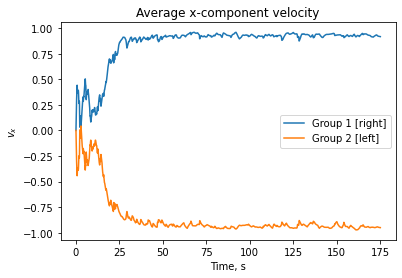

In [6]:
# Ploting velocity data
uData_p = np.array(uData)
vData_p = np.array(vData)
print(uData_p.shape)
order_g1 = np.mean(uData_p[:, :g1], axis = 1)
order_g2 = np.mean(uData_p[:, g1:], axis = 1)
t = np.arange(0, totalTime, deltaT)


# plt.figure()
plt.plot(t, order_g1[:-1], label = 'Group 1 [right]')
plt.plot(t, order_g2[:-1], label = 'Group 2 [left]')
# plt.xlim([0, 10])
plt.title('Average x-component velocity')
plt.xlabel('Time, s')
plt.ylabel(r'$v_{x}$')
# plt.axvline(13)
plt.legend()

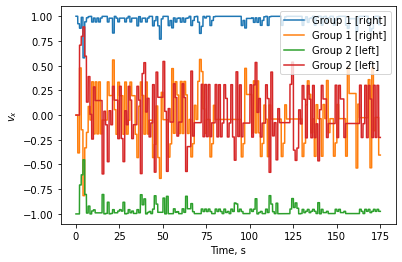

In [8]:
# Ploting desvelocity data
desdir_p = np.array(desdirs)

# print(uData_p.shape)
order_g1 = np.mean(desdir_p[:, :g1], axis = 1)
order_g2 = np.mean(desdir_p[:, g1:], axis = 1)
t = np.arange(deltaT, totalTime, deltaT)


# plt.figure()
plt.plot(t, order_g1[:-1], label = 'Group 1 [right]')
plt.plot(t, order_g2[:-1], label = 'Group 2 [left]')
# plt.xlim([0, 10])
# plt.title('Average x-component velocity')
plt.xlabel('Time, s')
plt.ylabel(r'$v_{x}$')
plt.legend()

Text(-0.5, 1500, '0.19')

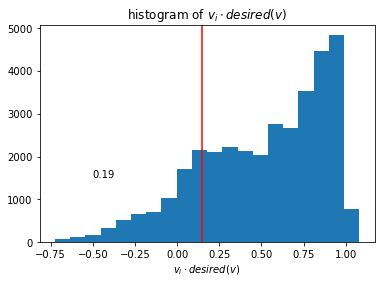

In [7]:
#Plotting histogram for only first agent (index 0)

plt.title('histogram of $v_i \\cdot desired(v)$')
plt.xlabel('$v_i \\cdot desired(v)$')
plt.axvline(0.15,color='red')
k=((np.array(uData)*np.cos(desired).reshape(-1,1).T)[:,0]).flatten()
plt.hist(k,20)
frac=1-(k>0.15).sum()/(k<500).sum()
plt.text(-0.5,1500,format(frac,'.2g'))

Text(-0.5, 150000, '0.043')

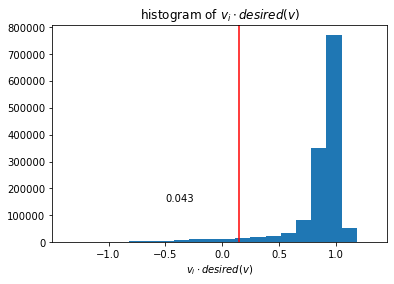

In [7]:
#Plotting histogram for all agents

plt.title('histogram of $v_i \\cdot desired(v)$')
plt.xlabel('$v_i \\cdot desired(v)$')
plt.axvline(0.15,color='red')
plt.hist((np.array(uData)*np.cos(desired).reshape(-1,1).T).flatten(),20)
frac=1-((np.array(uData)*np.cos(desired).reshape(-1,1).T).flatten()>0.15).sum()/((np.array(uData)*np.cos(desired).reshape(-1,1).T).flatten()<500).sum()
plt.text(-0.5,150000,format(frac,'.2g'))

Text(0.5, 1.0, 'average force over time')

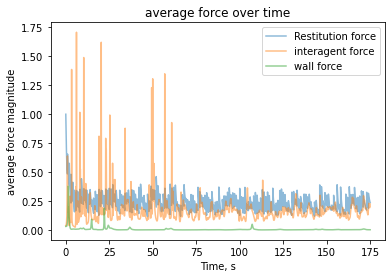

In [10]:
t = np.arange(0, totalTime, deltaT)
forces=np.array(forces)
plt.plot(t,((forces[:,0,:,0]**2+forces[:,0,:,1]**2)**0.5).mean(axis=1),alpha=0.5,label='Restitution force')
plt.plot(t,((forces[:,1,:,0]**2+forces[:,1,:,1]**2)**0.5).mean(axis=1),alpha=0.5,label='interagent force')
plt.plot(t,((forces[:,2,:,0]**2+forces[:,2,:,1]**2)**0.5).mean(axis=1),alpha=0.5,label='wall force')
plt.legend()
plt.xlabel('Time, s')
plt.ylabel('average force magnitude')
plt.title('average force over time')

In [10]:
xData = np.array(xData).T
yData = np.array(yData).T
filename='./presplots/fsm-2agents-alldirs'
for i in range(0,timeStep,125):
# for i in (14*200,14*200+1):
    plt.figure()
    for ag in range(xData.shape[0]):
        xpos=(xData[ag,i])
        ypos=(yData[ag,i])
        vx=uData[i][ag]
        vy=vData[i][ag]
        desx=desdirs[i][ag,0]
        desy=desdirs[i][ag,1]
        # dir=cmath.rect(1,dirdata[t,ag])
        plt.gca().add_patch(plt.Circle((xpos,ypos),1,fc='red' if ag<g1 else 'blue'))
        plt.arrow(xpos,ypos,vx,vy)
        plt.arrow(xpos,ypos,desx,desy,color='white',alpha=0.5)
        # plt.arrow(xpos,ypos,np.real(dir),np.imag(dir))
    plt.xlim(-1,Lx+1)
    plt.ylim(-1,Ly+1)
    plt.axhline(0)
    plt.axhline(Ly)
    plt.gca().set_aspect(1)
    plt.savefig(filename+'_prop_'+str(i)+'.png',facecolor='white')
    plt.close()

a
